In [3]:
import pennylane as qml
import pennylane.numpy as np
import jax.numpy as jnp
from scipy.special import legendre
from scipy.integrate import quad
import jax
import optax

from tqdm.notebook import tqdm


from time import time
import pickle

import matplotlib.pyplot as plt

import os, sys, argparse

parent = os.path.abspath('../src/')
sys.path.insert(1, parent)

from perceptron import Perceptron



# Set to float64 precision and remove jax CPU/GPU warning
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")


In [4]:
perceptron_qubits = 2

dev = qml.device("default.qubit.jax", wires = perceptron_qubits)

# transverse_field_coefficient = args.field
pulse_basis = 2
# n_steps = 50
# lr = args.lr
random_seed = 7

t0 = 0.0
tf = 1.0
# n_steps = 50


In [5]:

perceptron = Perceptron(perceptron_qubits, pulse_basis, basis='gaussian', pulse_width=0.5)

H =  perceptron.H


param_vector = perceptron.get_random_parameter_vector(random_seed)
param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)


print(param_vector)

print(param_list)


[0.65433892 0.96543909 0.05625912 0.46084293 0.77052822 0.99609687
 0.31379293 0.29736026 0.93472931]
[Array(0.65433892, dtype=float64), Array([0.96543909, 0.05625912], dtype=float64), Array([0.46084293, 0.77052822], dtype=float64), Array([0.99609687, 0.31379293], dtype=float64), Array([0.29736026, 0.93472931], dtype=float64)]


In [6]:
perceptron.field_basis_functions[0](0+0.9e-4)

Array(0.32809888, dtype=float64)

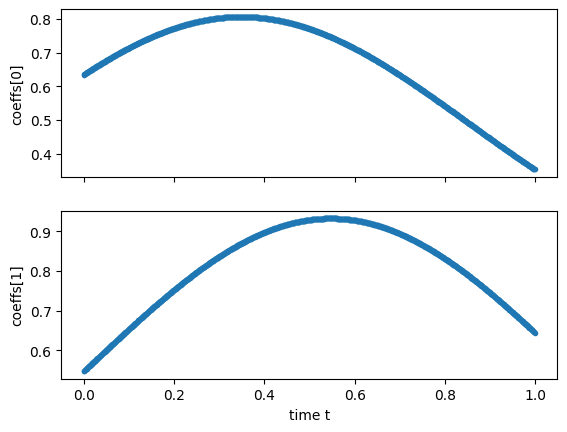

In [7]:
ts = jnp.linspace(0.0, 1, 1000)[:-1]

param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

fig, axs = plt.subplots(nrows=perceptron_qubits, sharex=True)
for i in range(perceptron_qubits):
    ax = axs[i]
    ax.plot(ts, perceptron.control_fields[i](param_list[i+perceptron_qubits-1], ts), ".-")
    ax.set_ylabel(f"coeffs[{i}]")
ax.set_xlabel("time t")
plt.show()

In [8]:
perceptron.control_fields_x[0](1,0.5)

# hmax=1e-3

Array([0.75476646, 0.75476646], dtype=float64)

In [9]:

def integrand_circuit_representation(k, t, t0, tf):

    if t != t0:
        qml.evolve(H)(param_list, [t0, t], hmax = 1e-3)

    perceptron.H_control_operators[k]

    if t!= tf:
        qml.evolve(H)(param_list, [t, tf], hmax = 1e-3)


def local_surjectivity(k, n, t0, tf, n_steps):

    approx_times = jnp.linspace(t0, tf, n_steps)

    dt = approx_times[1]

    dUdtheta = jnp.zeros((2**perceptron_qubits, 2**perceptron_qubits))

    # g_n = lambda t: jnp.cos(2*jnp.pi*(t)*n)
    # g_n = lambda t: t**n
    # g_n = lambda t: 1

    g_n = perceptron.field_basis_functions[n]
    

    for t in tqdm(approx_times):
        # print(t)
        # print(t)
        integrand_matrix = qml.matrix(integrand_circuit_representation)(k, t, t0, tf)
        # print(integrand_matrix)

        dUdtheta += g_n(t) * integrand_matrix * dt

    return dUdtheta

In [11]:
total_control_fields = 2*perceptron_qubits

determinant_dictionary = {}
# X = [int(1e3)]
X = [10, 50, 100]

In [12]:
for n_steps in X:

    determinant_matrix = np.zeros((total_control_fields, pulse_basis))
    # eigenvalues_matrix = np.empty((total_control_fields, pulse_basis), dtype=object)

    for k in range(total_control_fields):
        print(f'Field: {k+1}')
        for n in range(pulse_basis):

            print(f'Pulse expansion terms: {n+1}')
            derivative = local_surjectivity(k,n, t0, tf, n_steps)
            eigenvalues_array = np.linalg.det(derivative)
            determinant_matrix[k,n] = eigenvalues_array
            print(eigenvalues_array)

            print(derivative)


    determinant_dictionary[f'{n_steps}'] = determinant_matrix

Field: 1
Pulse expansion terms: 1


  0%|          | 0/10 [00:00<?, ?it/s]

(0.2515989819364374+1.3966549135904084e-17j)
[[ 0.03733543-0.26068357j -0.17028044-0.21722891j -0.20062251-0.13306304j
   0.21901429+0.5001403j ]
 [ 0.1869146 -0.20036754j  0.03843643+0.27156202j -0.53924832-0.09197949j
  -0.16762591-0.15473042j]
 [ 0.21223906-0.11850431j -0.49940235-0.21820307j  0.03818002+0.27048082j
  -0.21053464-0.16294181j]
 [-0.09089497-0.53834168j  0.15625291-0.16958496j  0.19364277-0.17965851j
   0.03847125-0.28123655j]]
Pulse expansion terms: 2


/var/folders/2q/r_plhm951s93s5nlm_f8ymjr0000gn/T/ipykernel_4489/2943466480.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  determinant_matrix[k,n] = eigenvalues_array


  0%|          | 0/10 [00:00<?, ?it/s]

(0.2515989819364374+1.3966549135904084e-17j)
[[ 0.03733543-0.26068357j -0.17028044-0.21722891j -0.20062251-0.13306304j
   0.21901429+0.5001403j ]
 [ 0.1869146 -0.20036754j  0.03843643+0.27156202j -0.53924832-0.09197949j
  -0.16762591-0.15473042j]
 [ 0.21223906-0.11850431j -0.49940235-0.21820307j  0.03818002+0.27048082j
  -0.21053464-0.16294181j]
 [-0.09089497-0.53834168j  0.15625291-0.16958496j  0.19364277-0.17965851j
   0.03847125-0.28123655j]]
Field: 2
Pulse expansion terms: 1


  0%|          | 0/10 [00:00<?, ?it/s]

(0.2515989819364374+1.3966549135904084e-17j)
[[ 0.03733543-0.26068357j -0.17028044-0.21722891j -0.20062251-0.13306304j
   0.21901429+0.5001403j ]
 [ 0.1869146 -0.20036754j  0.03843643+0.27156202j -0.53924832-0.09197949j
  -0.16762591-0.15473042j]
 [ 0.21223906-0.11850431j -0.49940235-0.21820307j  0.03818002+0.27048082j
  -0.21053464-0.16294181j]
 [-0.09089497-0.53834168j  0.15625291-0.16958496j  0.19364277-0.17965851j
   0.03847125-0.28123655j]]
Pulse expansion terms: 2


  0%|          | 0/10 [00:00<?, ?it/s]

(0.2515989819364374+1.3966549135904084e-17j)
[[ 0.03733543-0.26068357j -0.17028044-0.21722891j -0.20062251-0.13306304j
   0.21901429+0.5001403j ]
 [ 0.1869146 -0.20036754j  0.03843643+0.27156202j -0.53924832-0.09197949j
  -0.16762591-0.15473042j]
 [ 0.21223906-0.11850431j -0.49940235-0.21820307j  0.03818002+0.27048082j
  -0.21053464-0.16294181j]
 [-0.09089497-0.53834168j  0.15625291-0.16958496j  0.19364277-0.17965851j
   0.03847125-0.28123655j]]
Field: 3
Pulse expansion terms: 1


  0%|          | 0/10 [00:00<?, ?it/s]

(0.2515989819364374+1.3966549135904084e-17j)
[[ 0.03733543-0.26068357j -0.17028044-0.21722891j -0.20062251-0.13306304j
   0.21901429+0.5001403j ]
 [ 0.1869146 -0.20036754j  0.03843643+0.27156202j -0.53924832-0.09197949j
  -0.16762591-0.15473042j]
 [ 0.21223906-0.11850431j -0.49940235-0.21820307j  0.03818002+0.27048082j
  -0.21053464-0.16294181j]
 [-0.09089497-0.53834168j  0.15625291-0.16958496j  0.19364277-0.17965851j
   0.03847125-0.28123655j]]
Pulse expansion terms: 2


  0%|          | 0/10 [00:00<?, ?it/s]

(0.2515989819364374+1.3966549135904084e-17j)
[[ 0.03733543-0.26068357j -0.17028044-0.21722891j -0.20062251-0.13306304j
   0.21901429+0.5001403j ]
 [ 0.1869146 -0.20036754j  0.03843643+0.27156202j -0.53924832-0.09197949j
  -0.16762591-0.15473042j]
 [ 0.21223906-0.11850431j -0.49940235-0.21820307j  0.03818002+0.27048082j
  -0.21053464-0.16294181j]
 [-0.09089497-0.53834168j  0.15625291-0.16958496j  0.19364277-0.17965851j
   0.03847125-0.28123655j]]
Field: 4
Pulse expansion terms: 1


  0%|          | 0/10 [00:00<?, ?it/s]

(0.2515989819364374+1.3966549135904084e-17j)
[[ 0.03733543-0.26068357j -0.17028044-0.21722891j -0.20062251-0.13306304j
   0.21901429+0.5001403j ]
 [ 0.1869146 -0.20036754j  0.03843643+0.27156202j -0.53924832-0.09197949j
  -0.16762591-0.15473042j]
 [ 0.21223906-0.11850431j -0.49940235-0.21820307j  0.03818002+0.27048082j
  -0.21053464-0.16294181j]
 [-0.09089497-0.53834168j  0.15625291-0.16958496j  0.19364277-0.17965851j
   0.03847125-0.28123655j]]
Pulse expansion terms: 2


  0%|          | 0/10 [00:00<?, ?it/s]

(0.2515989819364374+1.3966549135904084e-17j)
[[ 0.03733543-0.26068357j -0.17028044-0.21722891j -0.20062251-0.13306304j
   0.21901429+0.5001403j ]
 [ 0.1869146 -0.20036754j  0.03843643+0.27156202j -0.53924832-0.09197949j
  -0.16762591-0.15473042j]
 [ 0.21223906-0.11850431j -0.49940235-0.21820307j  0.03818002+0.27048082j
  -0.21053464-0.16294181j]
 [-0.09089497-0.53834168j  0.15625291-0.16958496j  0.19364277-0.17965851j
   0.03847125-0.28123655j]]
Field: 1
Pulse expansion terms: 1


  0%|          | 0/50 [00:00<?, ?it/s]

(0.19686343135555956+4.371246283953123e-17j)
[[ 0.0351144 -0.24517586j -0.16015069-0.20430626j -0.18868775-0.1251473j
   0.20598542+0.47038763j]
 [ 0.1757953 -0.18844795j  0.0361499 +0.25540716j -0.50716917-0.08650775j
  -0.15765407-0.14552572j]
 [ 0.19961325-0.11145465j -0.46969358-0.20522247j  0.03590874+0.25439029j
  -0.19801022-0.15324862j]
 [-0.08548775-0.50631647j  0.14695763-0.15949658j  0.18212323-0.16897087j
   0.03618265-0.26450617j]]
Pulse expansion terms: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(0.19686343135555956+4.371246283953123e-17j)
[[ 0.0351144 -0.24517586j -0.16015069-0.20430626j -0.18868775-0.1251473j
   0.20598542+0.47038763j]
 [ 0.1757953 -0.18844795j  0.0361499 +0.25540716j -0.50716917-0.08650775j
  -0.15765407-0.14552572j]
 [ 0.19961325-0.11145465j -0.46969358-0.20522247j  0.03590874+0.25439029j
  -0.19801022-0.15324862j]
 [-0.08548775-0.50631647j  0.14695763-0.15949658j  0.18212323-0.16897087j
   0.03618265-0.26450617j]]
Field: 2
Pulse expansion terms: 1


  0%|          | 0/50 [00:00<?, ?it/s]

(0.19686343135555956+4.371246283953123e-17j)
[[ 0.0351144 -0.24517586j -0.16015069-0.20430626j -0.18868775-0.1251473j
   0.20598542+0.47038763j]
 [ 0.1757953 -0.18844795j  0.0361499 +0.25540716j -0.50716917-0.08650775j
  -0.15765407-0.14552572j]
 [ 0.19961325-0.11145465j -0.46969358-0.20522247j  0.03590874+0.25439029j
  -0.19801022-0.15324862j]
 [-0.08548775-0.50631647j  0.14695763-0.15949658j  0.18212323-0.16897087j
   0.03618265-0.26450617j]]
Pulse expansion terms: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(0.19686343135555956+4.371246283953123e-17j)
[[ 0.0351144 -0.24517586j -0.16015069-0.20430626j -0.18868775-0.1251473j
   0.20598542+0.47038763j]
 [ 0.1757953 -0.18844795j  0.0361499 +0.25540716j -0.50716917-0.08650775j
  -0.15765407-0.14552572j]
 [ 0.19961325-0.11145465j -0.46969358-0.20522247j  0.03590874+0.25439029j
  -0.19801022-0.15324862j]
 [-0.08548775-0.50631647j  0.14695763-0.15949658j  0.18212323-0.16897087j
   0.03618265-0.26450617j]]
Field: 3
Pulse expansion terms: 1


  0%|          | 0/50 [00:00<?, ?it/s]

(0.19686343135555956+4.371246283953123e-17j)
[[ 0.0351144 -0.24517586j -0.16015069-0.20430626j -0.18868775-0.1251473j
   0.20598542+0.47038763j]
 [ 0.1757953 -0.18844795j  0.0361499 +0.25540716j -0.50716917-0.08650775j
  -0.15765407-0.14552572j]
 [ 0.19961325-0.11145465j -0.46969358-0.20522247j  0.03590874+0.25439029j
  -0.19801022-0.15324862j]
 [-0.08548775-0.50631647j  0.14695763-0.15949658j  0.18212323-0.16897087j
   0.03618265-0.26450617j]]
Pulse expansion terms: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(0.19686343135555956+4.371246283953123e-17j)
[[ 0.0351144 -0.24517586j -0.16015069-0.20430626j -0.18868775-0.1251473j
   0.20598542+0.47038763j]
 [ 0.1757953 -0.18844795j  0.0361499 +0.25540716j -0.50716917-0.08650775j
  -0.15765407-0.14552572j]
 [ 0.19961325-0.11145465j -0.46969358-0.20522247j  0.03590874+0.25439029j
  -0.19801022-0.15324862j]
 [-0.08548775-0.50631647j  0.14695763-0.15949658j  0.18212323-0.16897087j
   0.03618265-0.26450617j]]
Field: 4
Pulse expansion terms: 1


  0%|          | 0/50 [00:00<?, ?it/s]

(0.19686343135555956+4.371246283953123e-17j)
[[ 0.0351144 -0.24517586j -0.16015069-0.20430626j -0.18868775-0.1251473j
   0.20598542+0.47038763j]
 [ 0.1757953 -0.18844795j  0.0361499 +0.25540716j -0.50716917-0.08650775j
  -0.15765407-0.14552572j]
 [ 0.19961325-0.11145465j -0.46969358-0.20522247j  0.03590874+0.25439029j
  -0.19801022-0.15324862j]
 [-0.08548775-0.50631647j  0.14695763-0.15949658j  0.18212323-0.16897087j
   0.03618265-0.26450617j]]
Pulse expansion terms: 2


  0%|          | 0/50 [00:00<?, ?it/s]

(0.19686343135555956+4.371246283953123e-17j)
[[ 0.0351144 -0.24517586j -0.16015069-0.20430626j -0.18868775-0.1251473j
   0.20598542+0.47038763j]
 [ 0.1757953 -0.18844795j  0.0361499 +0.25540716j -0.50716917-0.08650775j
  -0.15765407-0.14552572j]
 [ 0.19961325-0.11145465j -0.46969358-0.20522247j  0.03590874+0.25439029j
  -0.19801022-0.15324862j]
 [-0.08548775-0.50631647j  0.14695763-0.15949658j  0.18212323-0.16897087j
   0.03618265-0.26450617j]]
Field: 1
Pulse expansion terms: 1


  0%|          | 0/100 [00:00<?, ?it/s]

(0.19109061638758146+5.303830052582653e-17j)
[[ 0.03485409-0.24335837j -0.15896349-0.20279173j -0.187289  -0.12421958j
   0.20445845+0.46690065j]
 [ 0.17449213-0.18705098j  0.03588192+0.25351382j -0.50340952-0.08586647j
  -0.15648538-0.14444693j]
 [ 0.19813351-0.11062843j -0.46621173-0.20370115j  0.03564255+0.25250449j
  -0.19654237-0.15211259j]
 [-0.08485403-0.50256314j  0.14586824-0.15831423j  0.18077315-0.16771828j
   0.03591442-0.26254538j]]
Pulse expansion terms: 2


  0%|          | 0/100 [00:00<?, ?it/s]

(0.19109061638758146+5.303830052582653e-17j)
[[ 0.03485409-0.24335837j -0.15896349-0.20279173j -0.187289  -0.12421958j
   0.20445845+0.46690065j]
 [ 0.17449213-0.18705098j  0.03588192+0.25351382j -0.50340952-0.08586647j
  -0.15648538-0.14444693j]
 [ 0.19813351-0.11062843j -0.46621173-0.20370115j  0.03564255+0.25250449j
  -0.19654237-0.15211259j]
 [-0.08485403-0.50256314j  0.14586824-0.15831423j  0.18077315-0.16771828j
   0.03591442-0.26254538j]]
Field: 2
Pulse expansion terms: 1


  0%|          | 0/100 [00:00<?, ?it/s]

(0.19109061638758146+5.303830052582653e-17j)
[[ 0.03485409-0.24335837j -0.15896349-0.20279173j -0.187289  -0.12421958j
   0.20445845+0.46690065j]
 [ 0.17449213-0.18705098j  0.03588192+0.25351382j -0.50340952-0.08586647j
  -0.15648538-0.14444693j]
 [ 0.19813351-0.11062843j -0.46621173-0.20370115j  0.03564255+0.25250449j
  -0.19654237-0.15211259j]
 [-0.08485403-0.50256314j  0.14586824-0.15831423j  0.18077315-0.16771828j
   0.03591442-0.26254538j]]
Pulse expansion terms: 2


  0%|          | 0/100 [00:00<?, ?it/s]

(0.19109061638758146+5.303830052582653e-17j)
[[ 0.03485409-0.24335837j -0.15896349-0.20279173j -0.187289  -0.12421958j
   0.20445845+0.46690065j]
 [ 0.17449213-0.18705098j  0.03588192+0.25351382j -0.50340952-0.08586647j
  -0.15648538-0.14444693j]
 [ 0.19813351-0.11062843j -0.46621173-0.20370115j  0.03564255+0.25250449j
  -0.19654237-0.15211259j]
 [-0.08485403-0.50256314j  0.14586824-0.15831423j  0.18077315-0.16771828j
   0.03591442-0.26254538j]]
Field: 3
Pulse expansion terms: 1


  0%|          | 0/100 [00:00<?, ?it/s]

(0.19109061638758146+5.303830052582653e-17j)
[[ 0.03485409-0.24335837j -0.15896349-0.20279173j -0.187289  -0.12421958j
   0.20445845+0.46690065j]
 [ 0.17449213-0.18705098j  0.03588192+0.25351382j -0.50340952-0.08586647j
  -0.15648538-0.14444693j]
 [ 0.19813351-0.11062843j -0.46621173-0.20370115j  0.03564255+0.25250449j
  -0.19654237-0.15211259j]
 [-0.08485403-0.50256314j  0.14586824-0.15831423j  0.18077315-0.16771828j
   0.03591442-0.26254538j]]
Pulse expansion terms: 2


  0%|          | 0/100 [00:00<?, ?it/s]

(0.19109061638758146+5.303830052582653e-17j)
[[ 0.03485409-0.24335837j -0.15896349-0.20279173j -0.187289  -0.12421958j
   0.20445845+0.46690065j]
 [ 0.17449213-0.18705098j  0.03588192+0.25351382j -0.50340952-0.08586647j
  -0.15648538-0.14444693j]
 [ 0.19813351-0.11062843j -0.46621173-0.20370115j  0.03564255+0.25250449j
  -0.19654237-0.15211259j]
 [-0.08485403-0.50256314j  0.14586824-0.15831423j  0.18077315-0.16771828j
   0.03591442-0.26254538j]]
Field: 4
Pulse expansion terms: 1


  0%|          | 0/100 [00:00<?, ?it/s]

(0.19109061638758146+5.303830052582653e-17j)
[[ 0.03485409-0.24335837j -0.15896349-0.20279173j -0.187289  -0.12421958j
   0.20445845+0.46690065j]
 [ 0.17449213-0.18705098j  0.03588192+0.25351382j -0.50340952-0.08586647j
  -0.15648538-0.14444693j]
 [ 0.19813351-0.11062843j -0.46621173-0.20370115j  0.03564255+0.25250449j
  -0.19654237-0.15211259j]
 [-0.08485403-0.50256314j  0.14586824-0.15831423j  0.18077315-0.16771828j
   0.03591442-0.26254538j]]
Pulse expansion terms: 2


  0%|          | 0/100 [00:00<?, ?it/s]

(0.19109061638758146+5.303830052582653e-17j)
[[ 0.03485409-0.24335837j -0.15896349-0.20279173j -0.187289  -0.12421958j
   0.20445845+0.46690065j]
 [ 0.17449213-0.18705098j  0.03588192+0.25351382j -0.50340952-0.08586647j
  -0.15648538-0.14444693j]
 [ 0.19813351-0.11062843j -0.46621173-0.20370115j  0.03564255+0.25250449j
  -0.19654237-0.15211259j]
 [-0.08485403-0.50256314j  0.14586824-0.15831423j  0.18077315-0.16771828j
   0.03591442-0.26254538j]]


In [13]:
determinant_dictionary

{'10': tensor([[0.25159898, 0.25159898],
         [0.25159898, 0.25159898],
         [0.25159898, 0.25159898],
         [0.25159898, 0.25159898]], requires_grad=True),
 '50': tensor([[0.19686343, 0.19686343],
         [0.19686343, 0.19686343],
         [0.19686343, 0.19686343],
         [0.19686343, 0.19686343]], requires_grad=True),
 '100': tensor([[0.19109062, 0.19109062],
         [0.19109062, 0.19109062],
         [0.19109062, 0.19109062],
         [0.19109062, 0.19109062]], requires_grad=True)}

In [14]:
total_pulse_data = []


for k in range(total_control_fields):
    for n in range(pulse_basis):

        determinant_data = []

        for key in determinant_dictionary:

            determinants = determinant_dictionary[key]
            
            determinant_data.append(determinants[k,n])

        total_pulse_data.append(determinant_data)

In [15]:
data_array = np.array(total_pulse_data)

data_array

tensor([[0.25159898, 0.19686343, 0.19109062],
        [0.25159898, 0.19686343, 0.19109062],
        [0.25159898, 0.19686343, 0.19109062],
        [0.25159898, 0.19686343, 0.19109062],
        [0.25159898, 0.19686343, 0.19109062],
        [0.25159898, 0.19686343, 0.19109062],
        [0.25159898, 0.19686343, 0.19109062],
        [0.25159898, 0.19686343, 0.19109062]], requires_grad=True)

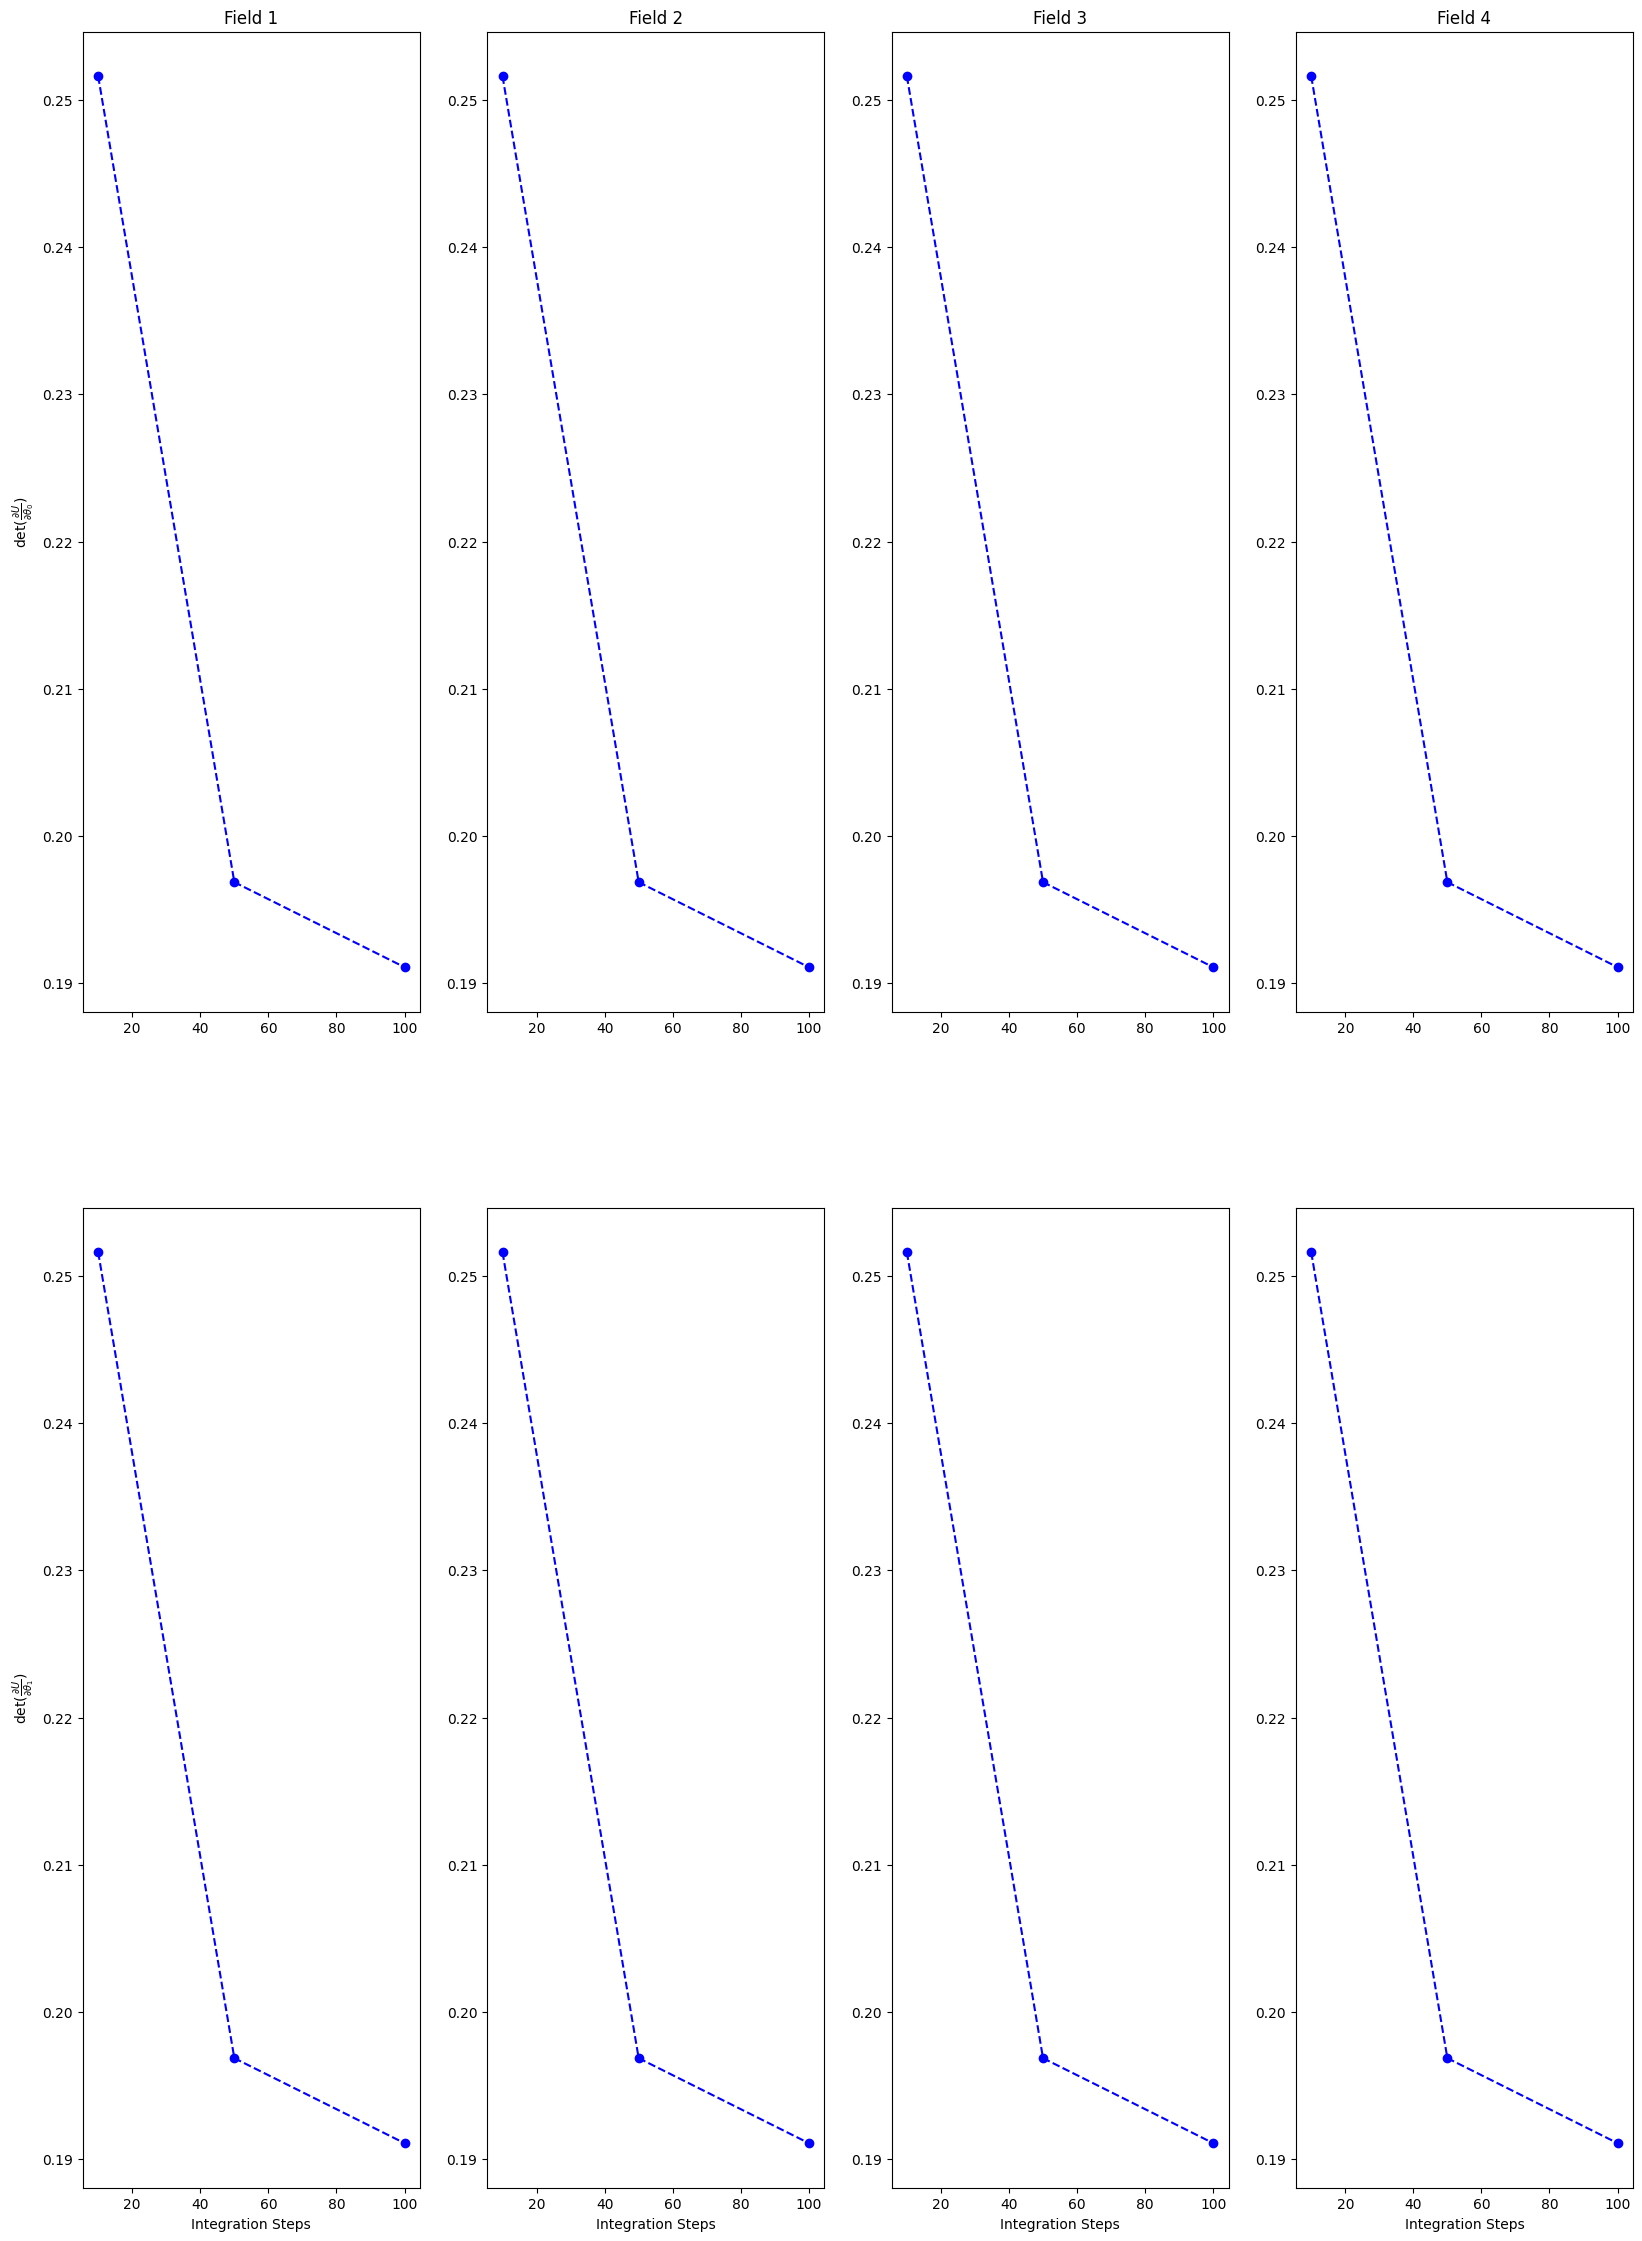

In [16]:
import matplotlib.pyplot as plt

data_array = np.reshape(data_array, (-1,2,3))

n_cols, n_rows, _ = data_array.shape

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 7*n_cols))
axes.shape

for ii in range(n_rows):
    for jj in range(n_cols):
        axes[ii,jj].plot(X, data_array[jj,ii], '--bo')


for i in range(n_rows):
    axes[i, 0].set_ylabel('det($\\frac{\\partial U}{\\partial \\theta_{'+ str(i) +'}}$)')

for i in range(n_cols):
    axes[0, i].set_title(f'Field {i+1}')

for i in range(n_cols):
    axes[n_rows-1, i].set_xlabel(f'Integration Steps')   

plt.show() 

{'25': tensor([[1.17737567e+00, 7.35859805e-02, 1.38621555e-08, 1.12907940e-04,
          8.19998575e-07],
         [1.17737567e+00, 7.35859805e-02, 1.38621555e-08, 1.12907940e-04,
          8.19998575e-07],
         [1.17737567e+00, 7.35859805e-02, 1.38621555e-08, 1.12907940e-04,
          8.19998575e-07],
         [1.17737567e+00, 7.35859805e-02, 1.38621555e-08, 1.12907940e-04,
          8.19998575e-07]], requires_grad=True),
 '50': tensor([[1.08416576e+00, 6.77603604e-02, 7.34635892e-10, 1.72092559e-04,
          4.27320243e-08],
         [1.08416576e+00, 6.77603604e-02, 7.34635892e-10, 1.72092559e-04,
          4.27320243e-08],
         [1.08416576e+00, 6.77603604e-02, 7.34635892e-10, 1.72092559e-04,
          4.27320243e-08],
         [1.08416576e+00, 6.77603604e-02, 7.34635892e-10, 1.72092559e-04,
          4.27320243e-08]], requires_grad=True),
 '75': tensor([[1.05515962e+00, 6.59474772e-02, 1.37452438e-10, 1.94727673e-04,
          7.95037401e-09],
         [1.05515962e+00, 6.59474772e-02, 1.37452438e-10, 1.94727673e-04,
          7.95037401e-09],
         [1.05515962e+00, 6.59474772e-02, 1.37452438e-10, 1.94727673e-04,
          7.95037401e-09],
         [1.05515962e+00, 6.59474772e-02, 1.37452438e-10, 1.94727673e-04,
          7.95037401e-09]], requires_grad=True)}